# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import fiona

pd.options.display.max_columns = None 

# set working directory
os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Load Data
no_spills = gpd.read_file('no_spills_cleaned.geojson')
spills = gpd.read_file('spills_cleaned.geojson')

In [3]:
print(no_spills.info())
print(no_spills.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4117 entries, 0 to 4116
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   operator_number         4117 non-null   int32   
 1   flowline_id             4117 non-null   float64 
 2   location_id             4117 non-null   float64 
 3   status                  4117 non-null   object  
 4   flowline_action         4117 non-null   object  
 5   location_type           4117 non-null   object  
 6   fluid                   4117 non-null   object  
 7   material                4117 non-null   object  
 8   diameter_in             4117 non-null   int32   
 9   length_ft               4117 non-null   int32   
 10  max_operating_pressure  4117 non-null   int32   
 11  shape_length            4117 non-null   int32   
 12  line_age_yr             4117 non-null   int32   
 13  risk                    4117 non-null   int32   
 14  geometry        

In [4]:
print(spills.info())
print(spills.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   operator_number         41 non-null     int32   
 1   flowline_id             41 non-null     float64 
 2   location_id             41 non-null     float64 
 3   status                  41 non-null     object  
 4   flowline_action         41 non-null     object  
 5   location_type           41 non-null     object  
 6   fluid                   41 non-null     object  
 7   material                41 non-null     object  
 8   diameter_in             41 non-null     int32   
 9   length_ft               41 non-null     int32   
 10  max_operating_pressure  41 non-null     int32   
 11  shape_length            41 non-null     int32   
 12  line_age_yr             41 non-null     int32   
 13  root_cause_type         41 non-null     object  
 14  risk                

In [5]:
# Combine both datasets
complete_data = pd.concat([no_spills,spills],ignore_index=True)

In [6]:
print(complete_data.info())
print(complete_data.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4158 entries, 0 to 4157
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   operator_number         4158 non-null   int32   
 1   flowline_id             4158 non-null   float64 
 2   location_id             4158 non-null   float64 
 3   status                  4158 non-null   object  
 4   flowline_action         4158 non-null   object  
 5   location_type           4158 non-null   object  
 6   fluid                   4158 non-null   object  
 7   material                4158 non-null   object  
 8   diameter_in             4158 non-null   int32   
 9   length_ft               4158 non-null   int32   
 10  max_operating_pressure  4158 non-null   int32   
 11  shape_length            4158 non-null   int32   
 12  line_age_yr             4158 non-null   int32   
 13  risk                    4158 non-null   int32   
 14  geometry        

In [7]:
complete_data['root_cause_type'].unique()

array([nan, 'Corrosion', 'Unknown', 'Incorrect Operation',
       'Equipment Failure', 'Other Outside Force Damage',
       'Natural Force Damage'], dtype=object)

### Match Operator # to Name

For future reference

In [8]:
# Load operator_mapping.csv
operator_mapping = pd.read_csv('operator_mapping.csv')
operator_mapping.rename(columns={'OPERATOR_NUM': 'operator_number'}, inplace=True)

# Extract unique operator_number values from complete_data
unique_operator_nums_complete_data = complete_data['operator_number'].unique()

# Filter the operator_mapping to keep only rows with operator numbers present in complete_data
filtered_operator_mapping = operator_mapping[operator_mapping['operator_number'].isin(unique_operator_nums_complete_data)].drop_duplicates().reset_index(drop=True)

# Display the filtered DataFrame
print(filtered_operator_mapping.to_string(index=False))

 operator_number                              operator_name
             710                           AEON ENERGY CORP
            3250                ANTELOPE ENERGY COMPANY LLC
            6720              ROBERT L BAYLESS PRODUCER LLC
            7125                       BEEMAN OIL & GAS LLC
            7800                          BEREN CORPORATION
            8960 BONANZA CREEK ENERGY OPERATING COMPANY LLC
           10000              BP AMERICA PRODUCTION COMPANY
           10017                       CHACO ENERGY COMPANY
           10071            HIGHPOINT OPERATING CORPORATION
           10085                        ARMOR PETROLEUM INC
           10110        GREAT WESTERN OPERATING COMPANY LLC
           10112           FOUNDATION ENERGY MANAGEMENT LLC
           10133                     HILCORP ENERGY COMPANY
           10261     BAYSWATER EXPLORATION & PRODUCTION LLC
           10299           KUENZLER & FLORA RESERVE COMPANY
           10312                        

In [9]:
unique_operator_nums = complete_data['operator_number'].unique()
print(unique_operator_nums.shape)
print(filtered_operator_mapping.shape)

(88,)
(89, 2)


In [10]:
# Check for duplicate operator numbers
duplicates = filtered_operator_mapping.duplicated(subset='operator_number', keep=False)

# Filter out the rows where operator number is duplicated
duplicate_rows = filtered_operator_mapping[duplicates]
duplicate_rows

,operator_number,operator_name
25,10531,GRIZZLY OPERATING LLC
26,10531,VANGUARD OPERATING LLC


In [11]:
# Save the resulting DataFrame to a CSV file
filtered_operator_mapping.to_csv('filtered_operator_mapping.csv', index=False)

# Exploratory Data Analysis

## Spatial Distribution

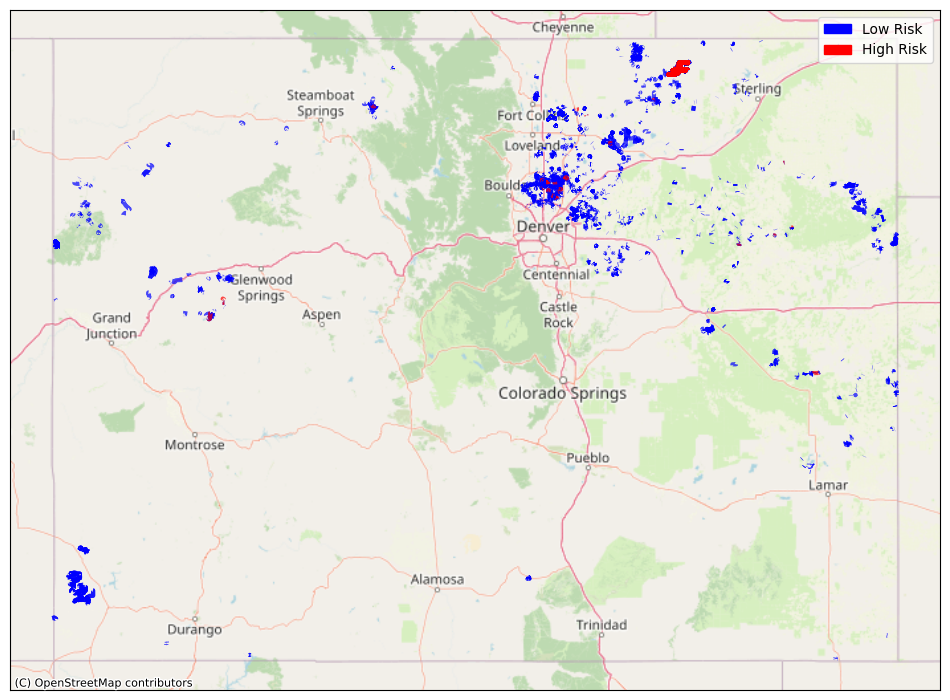

In [12]:
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches

# Convert CRS to EPSG:3857 for contextily base map
complete_data_wm = complete_data.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Sort the data by risk level, assuming higher risk has higher numerical value
complete_data_wm = complete_data_wm.sort_values(by='risk')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size
complete_data_wm.plot(column='risk', ax=ax, cmap=cmap, norm=norm, alpha=0.7, linewidth=3)  # Increased line width for better visibility

# Add base map
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# ax.set_title('Spatial Distribution of Flowline Risk in Colorado')
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

plt.show()

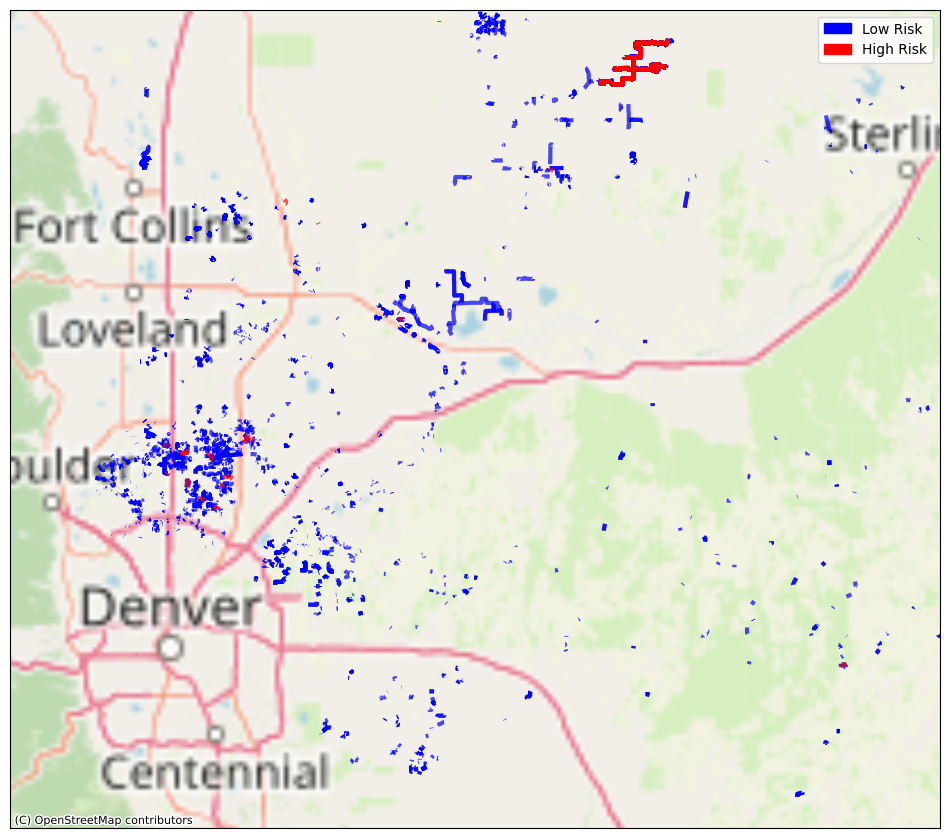

In [13]:
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Convert CRS to EPSG:3857 for contextily base map
complete_data_wm = complete_data.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Sort data by risk level (red on top)
complete_data_wm = complete_data_wm.sort_values(by='risk')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))
complete_data_wm.plot(
    column='risk', ax=ax, cmap=cmap, norm=norm,
    alpha=0.7, linewidth=3
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# Clean ticks
ax.set_xticks([])
ax.set_yticks([])

# 👇 Zoom to region including Boulder, Fort Collins, Sterling, and red cluster
ax.set_xlim(-11730000, -11480000)
ax.set_ylim(4780000, 5000000)  # Was (4860000, 5000000)

plt.show()

## Risk Frequency Graphs

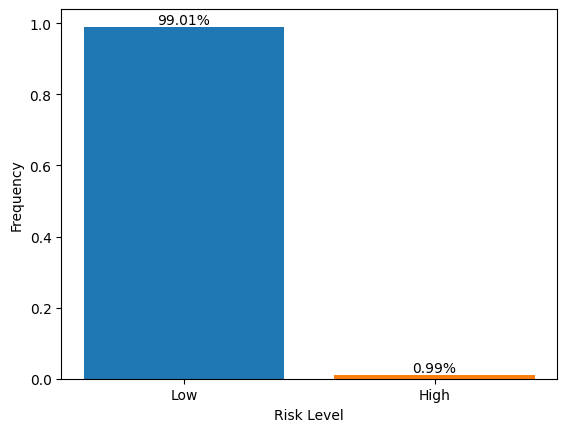

In [14]:
# Calculate total number of instances
total_instances = len(complete_data)

# Calculate frequencies of low and high risk
low_risk_frequency = (complete_data['risk'] == 0).sum() / total_instances
high_risk_frequency = (complete_data['risk'] == 1).sum() / total_instances

# Plot frequency map
bars = plt.bar(['Low', 'High'], [low_risk_frequency, high_risk_frequency], color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Risk Level')
plt.ylabel('Frequency')
# plt.title('Total High/Low Risk Frequency')

# Add percentages above each bar
for bar, percentage in zip(bars, [low_risk_frequency, high_risk_frequency]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.2%}', ha='center', va='bottom')

plt.show()

This operation filters the dataset to include only those parameters that have at least one instance of high risk (risk = 1). It then compares the frequency of these parameters when the risk is 0 versus when the risk is 1. The result is a series of bar plots showing how often each parameter occurs at different risk levels.

In [15]:
import math

def plot_risk_vs_parameter_grid_auto(data, parameters, titles, xlabels, ylabel, n_cols=2):
    n = len(parameters)
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows), sharey=False)
    axes = axes.flatten()

    for i, (param, title, xlabel) in enumerate(zip(parameters, titles, xlabels)):
        ax = axes[i]

        risk_1_data = data[data['risk'] == 1][param].unique()
        filtered_data = data[data[param].isin(risk_1_data)]

        counts = filtered_data.groupby([param, 'risk']).size().reset_index(name='counts')
        pivot_counts = counts.pivot(index=param, columns='risk', values='counts').fillna(0)
        pivot_counts = pivot_counts.div(pivot_counts.sum(axis=1), axis=0)

        pivot_counts.plot(kind='bar', stacked=False, ax=ax, legend=False)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', labelrotation=45)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, ['Low', 'High'], title='Risk', loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

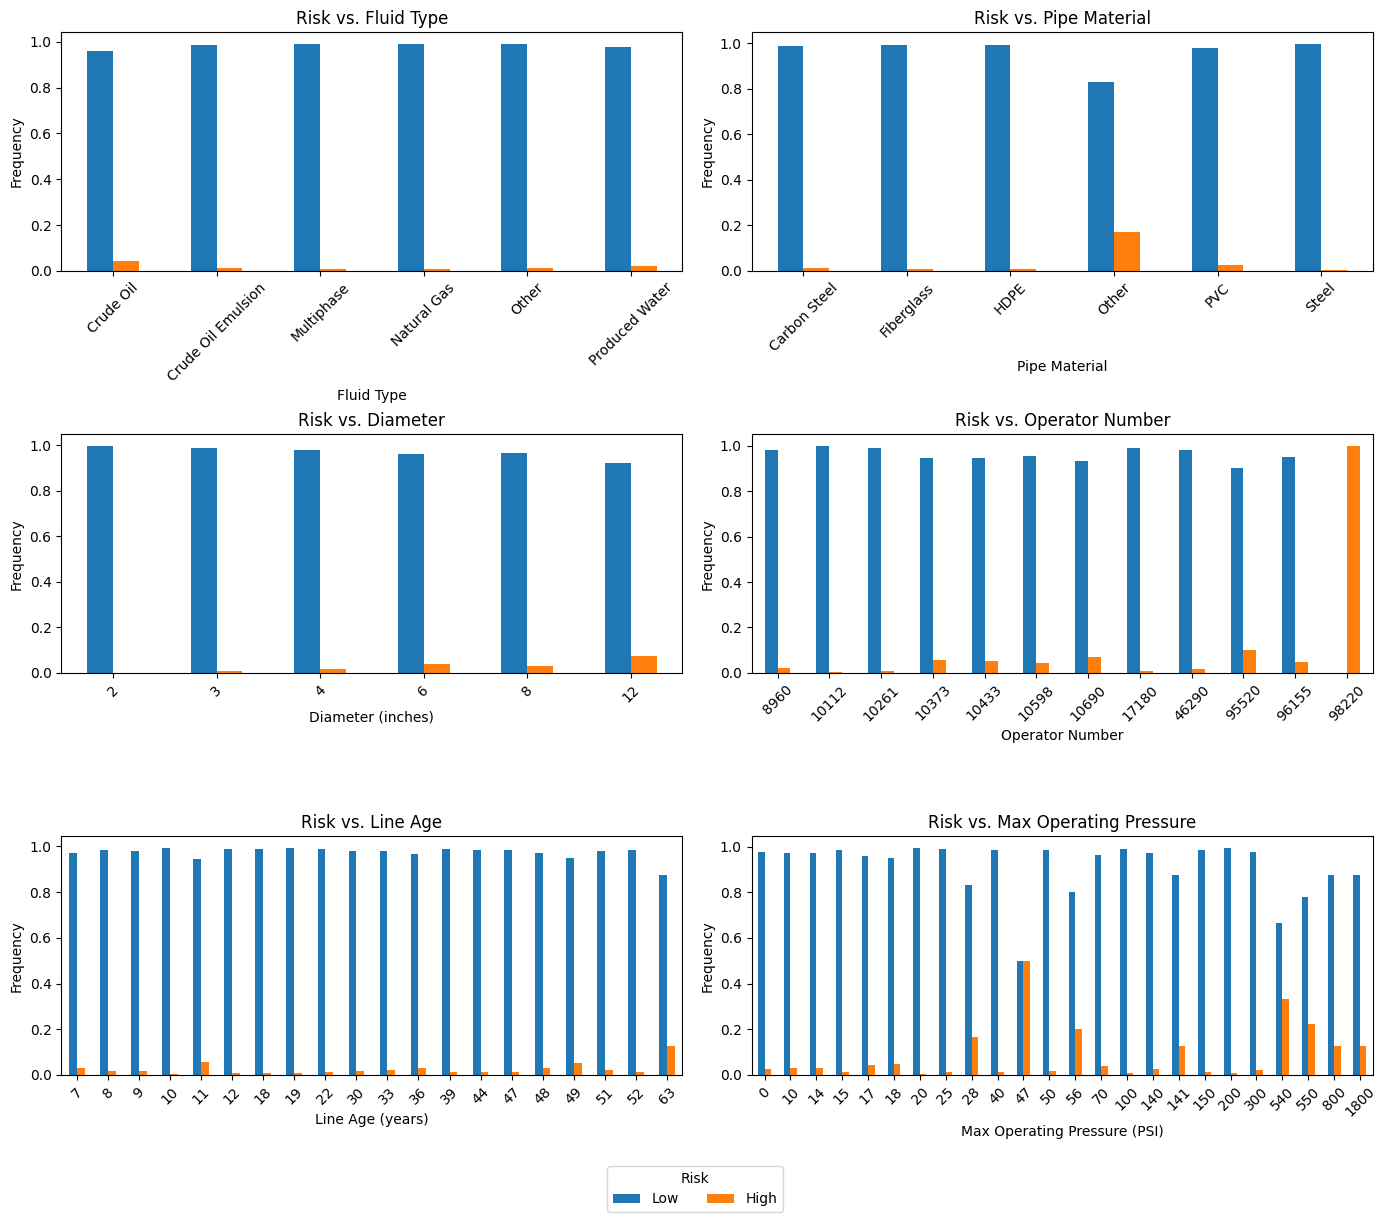

In [16]:
plot_risk_vs_parameter_grid_auto(
    complete_data,
    parameters=[
        #'status',
        # 'flowline_action',
        # 'location_type',
        'fluid',
        'material',
        'diameter_in',
        # 'length_ft',
        'operator_number',
        'line_age_yr',
        'max_operating_pressure',
        # 'num_lines',
        # 'bbox_area'
    ],
    titles=[
        # 'Risk vs. Status',
        # 'Risk vs. Flowline Action',
        # 'Risk vs. Location Type',
        'Risk vs. Fluid Type',
        'Risk vs. Pipe Material',
        'Risk vs. Diameter',
        # 'Risk vs. Length',
        'Risk vs. Operator Number',
        'Risk vs. Line Age',
        'Risk vs. Max Operating Pressure',
        # 'Risk vs. Number of Lines',
        # 'Risk vs. Bounding Box Area'
    ],
    xlabels=[
        # 'Status',
        # 'Flowline Action',
        # 'Location Type',
        'Fluid Type',
        'Pipe Material',
        'Diameter (inches)',
        # 'Length (ft)',
        'Operator Number',
        'Line Age (years)',
        'Max Operating Pressure (PSI)',
        # 'Number of Lines',
        # 'Bounding Box Area ($ft^2$)'
    ],
    ylabel='Frequency'
)

In [17]:
import pandas as pd

# Count number of flowlines per operator
flowlines_per_operator = complete_data['operator_number'].value_counts()

# Summary statistics
total_operators = flowlines_per_operator.shape[0]
total_flowlines = flowlines_per_operator.sum()
mean_flowlines = flowlines_per_operator.mean()
median_flowlines = flowlines_per_operator.median()
max_flowlines = flowlines_per_operator.max()
min_flowlines = flowlines_per_operator.min()

# Percentage of flowlines owned by top N operators
top_n = 10
flowlines_top_n = flowlines_per_operator.head(top_n).sum()
percent_top_n = (flowlines_top_n / total_flowlines) * 100

# Display results
print(f"Total operators: {total_operators}")
print(f"Total flowlines: {total_flowlines}")
print(f"Mean flowlines per operator: {mean_flowlines:.2f}")
print(f"Median flowlines per operator: {median_flowlines}")
print(f"Min flowlines per operator: {min_flowlines}")
print(f"Max flowlines per operator: {max_flowlines}")
print(f"Top {top_n} operators own {flowlines_top_n} flowlines ({percent_top_n:.2f}% of total)")

Total operators: 88
Total flowlines: 4158
Mean flowlines per operator: 47.25
Median flowlines per operator: 6.0
Min flowlines per operator: 1
Max flowlines per operator: 837
Top 10 operators own 2994 flowlines (72.01% of total)


In [18]:
unique_flowlines = complete_data['flowline_id'].nunique()
print(f"Number of unique flowline IDs: {unique_flowlines}")

# gas gathering lines, dont use for safety within ECMC 

Number of unique flowline IDs: 3389


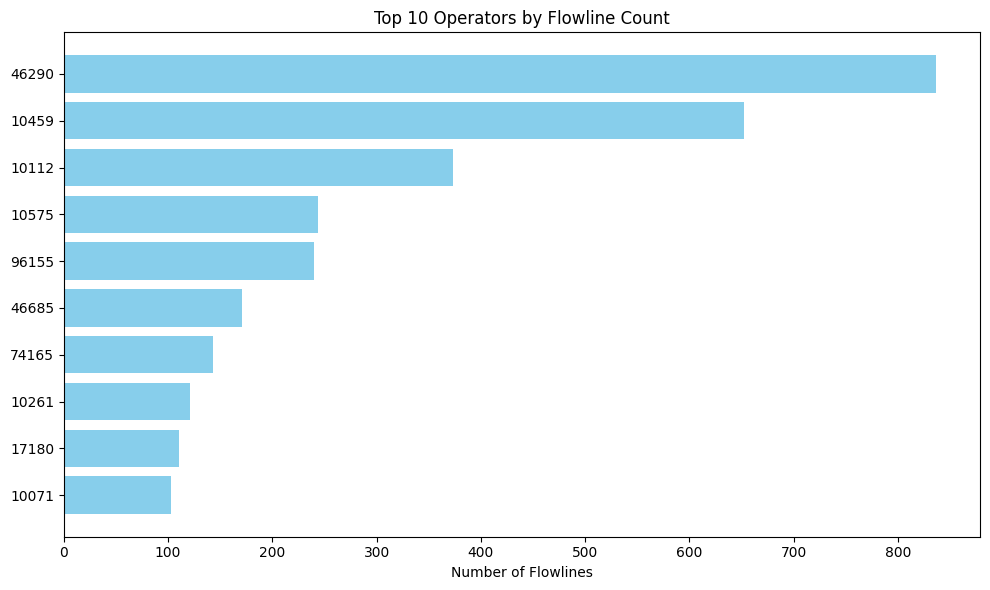

In [19]:
# Count number of flowlines per operator
flowlines_per_operator = complete_data['operator_number'].value_counts().reset_index()
flowlines_per_operator.columns = ['Operator Number', 'Flowline Count']

# Optional: save to CSV or display top N
flowlines_per_operator.head(10)  # top 10 operators by count

# Plot if needed
import matplotlib.pyplot as plt

top_n = 10
top_operators = flowlines_per_operator.head(top_n)
plt.figure(figsize=(10, 6))
plt.barh(top_operators['Operator Number'].astype(str), top_operators['Flowline Count'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Number of Flowlines")
plt.title(f"Top {top_n} Operators by Flowline Count")
plt.tight_layout()
plt.savefig("top_operators_flowlines.png")
plt.show()

# One hot encoding

Turning text columns into numbers

Ordinal Data: If the categories have a meaningful order or rank, they are ordinal. In such cases, assigning numbers like 1-5 makes sense as the numerical order reflects the order of the categories. For example, ratings from 'Very Poor' to 'Excellent' could be encoded as 1 through 5.

Nominal Data: If the categories do not have an inherent order, they are nominal. For such data, using numeric encoding (like 1, 2, 3, etc.) can inadvertently imply a hierarchy or order that doesn't actually exist, which might lead to misleading results in your model. Instead, you should use one-hot encoding (also known as dummy variables).

In [20]:
complete_data = complete_data.drop(columns=['operator_number', 'flowline_id', 'location_id', 'shape_length'])

In [21]:
complete_data_transformed = pd.get_dummies(complete_data, columns=['status', 'flowline_action', 'location_type', 'fluid', 'material', 'root_cause_type'], drop_first=True)

# List of original columns that are not one-hot encoded
original_columns = no_spills.columns.tolist()

# List of new columns that are the result of get_dummies
new_dummy_columns = [col for col in complete_data_transformed.columns if col not in original_columns]

# Convert only the dummy columns to int
complete_data_transformed[new_dummy_columns] = complete_data_transformed[new_dummy_columns].astype(int)

In [22]:
print(complete_data_transformed.info())
print(complete_data_transformed.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4158 entries, 0 to 4157
Data columns (total 63 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   diameter_in                                   4158 non-null   int32   
 1   length_ft                                     4158 non-null   int32   
 2   max_operating_pressure                        4158 non-null   int32   
 3   line_age_yr                                   4158 non-null   int32   
 4   risk                                          4158 non-null   int32   
 5   geometry                                      4158 non-null   geometry
 6   status_Active                                 4158 non-null   int64   
 7   status_Future                                 4158 non-null   int64   
 8   status_Inactive                               4158 non-null   int64   
 9   status_Out of Service                       

### Geometery Feature Extraction

This line calculates the total length of each geometry in the GeoDataFrame. For LineString objects, this will be the actual length of the line. For MultiLineString objects, it computes the sum of the lengths of all the individual LineStrings within the MultiLineString. The length is usually in the units of the coordinate reference system used by the GeoDataFrame (e.g., meters, feet, etc.). This feature is useful in many contexts, such as calculating the length of rivers, roads, or boundaries.

In [23]:
# complete_data_transformed['length'] = complete_data_transformed['geometry'].length

This line of code calculates the number of line segments in each geometry. If the geometry is a MultiLineString, it counts how many individual LineString objects it contains. If the geometry is not a MultiLineString (implying it could be a single LineString or another type of geometry), it assigns a count of 1. This feature helps in understanding the complexity or fragmentation of the spatial feature being analyzed, such as road segments or stream networks.

In [24]:
complete_data_transformed['num_lines'] = complete_data_transformed['geometry'].apply(lambda x: len(x.geoms) if x.geom_type == 'MultiLineString' else 1)

This line computes the area of the bounding box that encloses each geometry. The bounding box is the smallest rectangle that completely contains the geometry, aligned with coordinate axes. Specifically, maxx, minx, maxy, and miny represent the maximum and minimum x and y coordinates of the geometry’s bounding box, respectively. The area is then calculated as the product of the rectangle’s width (maxx - minx) and height (maxy - miny). This feature can be particularly useful for assessing the spatial extent or the "footprint" of geometries, which is relevant in applications like spatial planning, habitat area calculation, or agricultural field sizes.

In [25]:
complete_data_transformed['bounds_area'] = complete_data_transformed['geometry'].bounds.apply(lambda x: (x['maxx'] - x['minx']) * (x['maxy'] - x['miny']), axis=1)

In [26]:
# Original GeoDataFrame with geometry
geo = complete_data_transformed[['geometry']]

from sklearn.model_selection import train_test_split

# Match geometry to test set (same split used in modeling)
_, test_indices = train_test_split(complete_data_transformed.index, test_size=0.3, random_state=42)
test_geometry = geo.loc[test_indices]

In [27]:
complete_data_transformed = complete_data_transformed.drop(columns=['geometry']) 

## Correlation Analysis

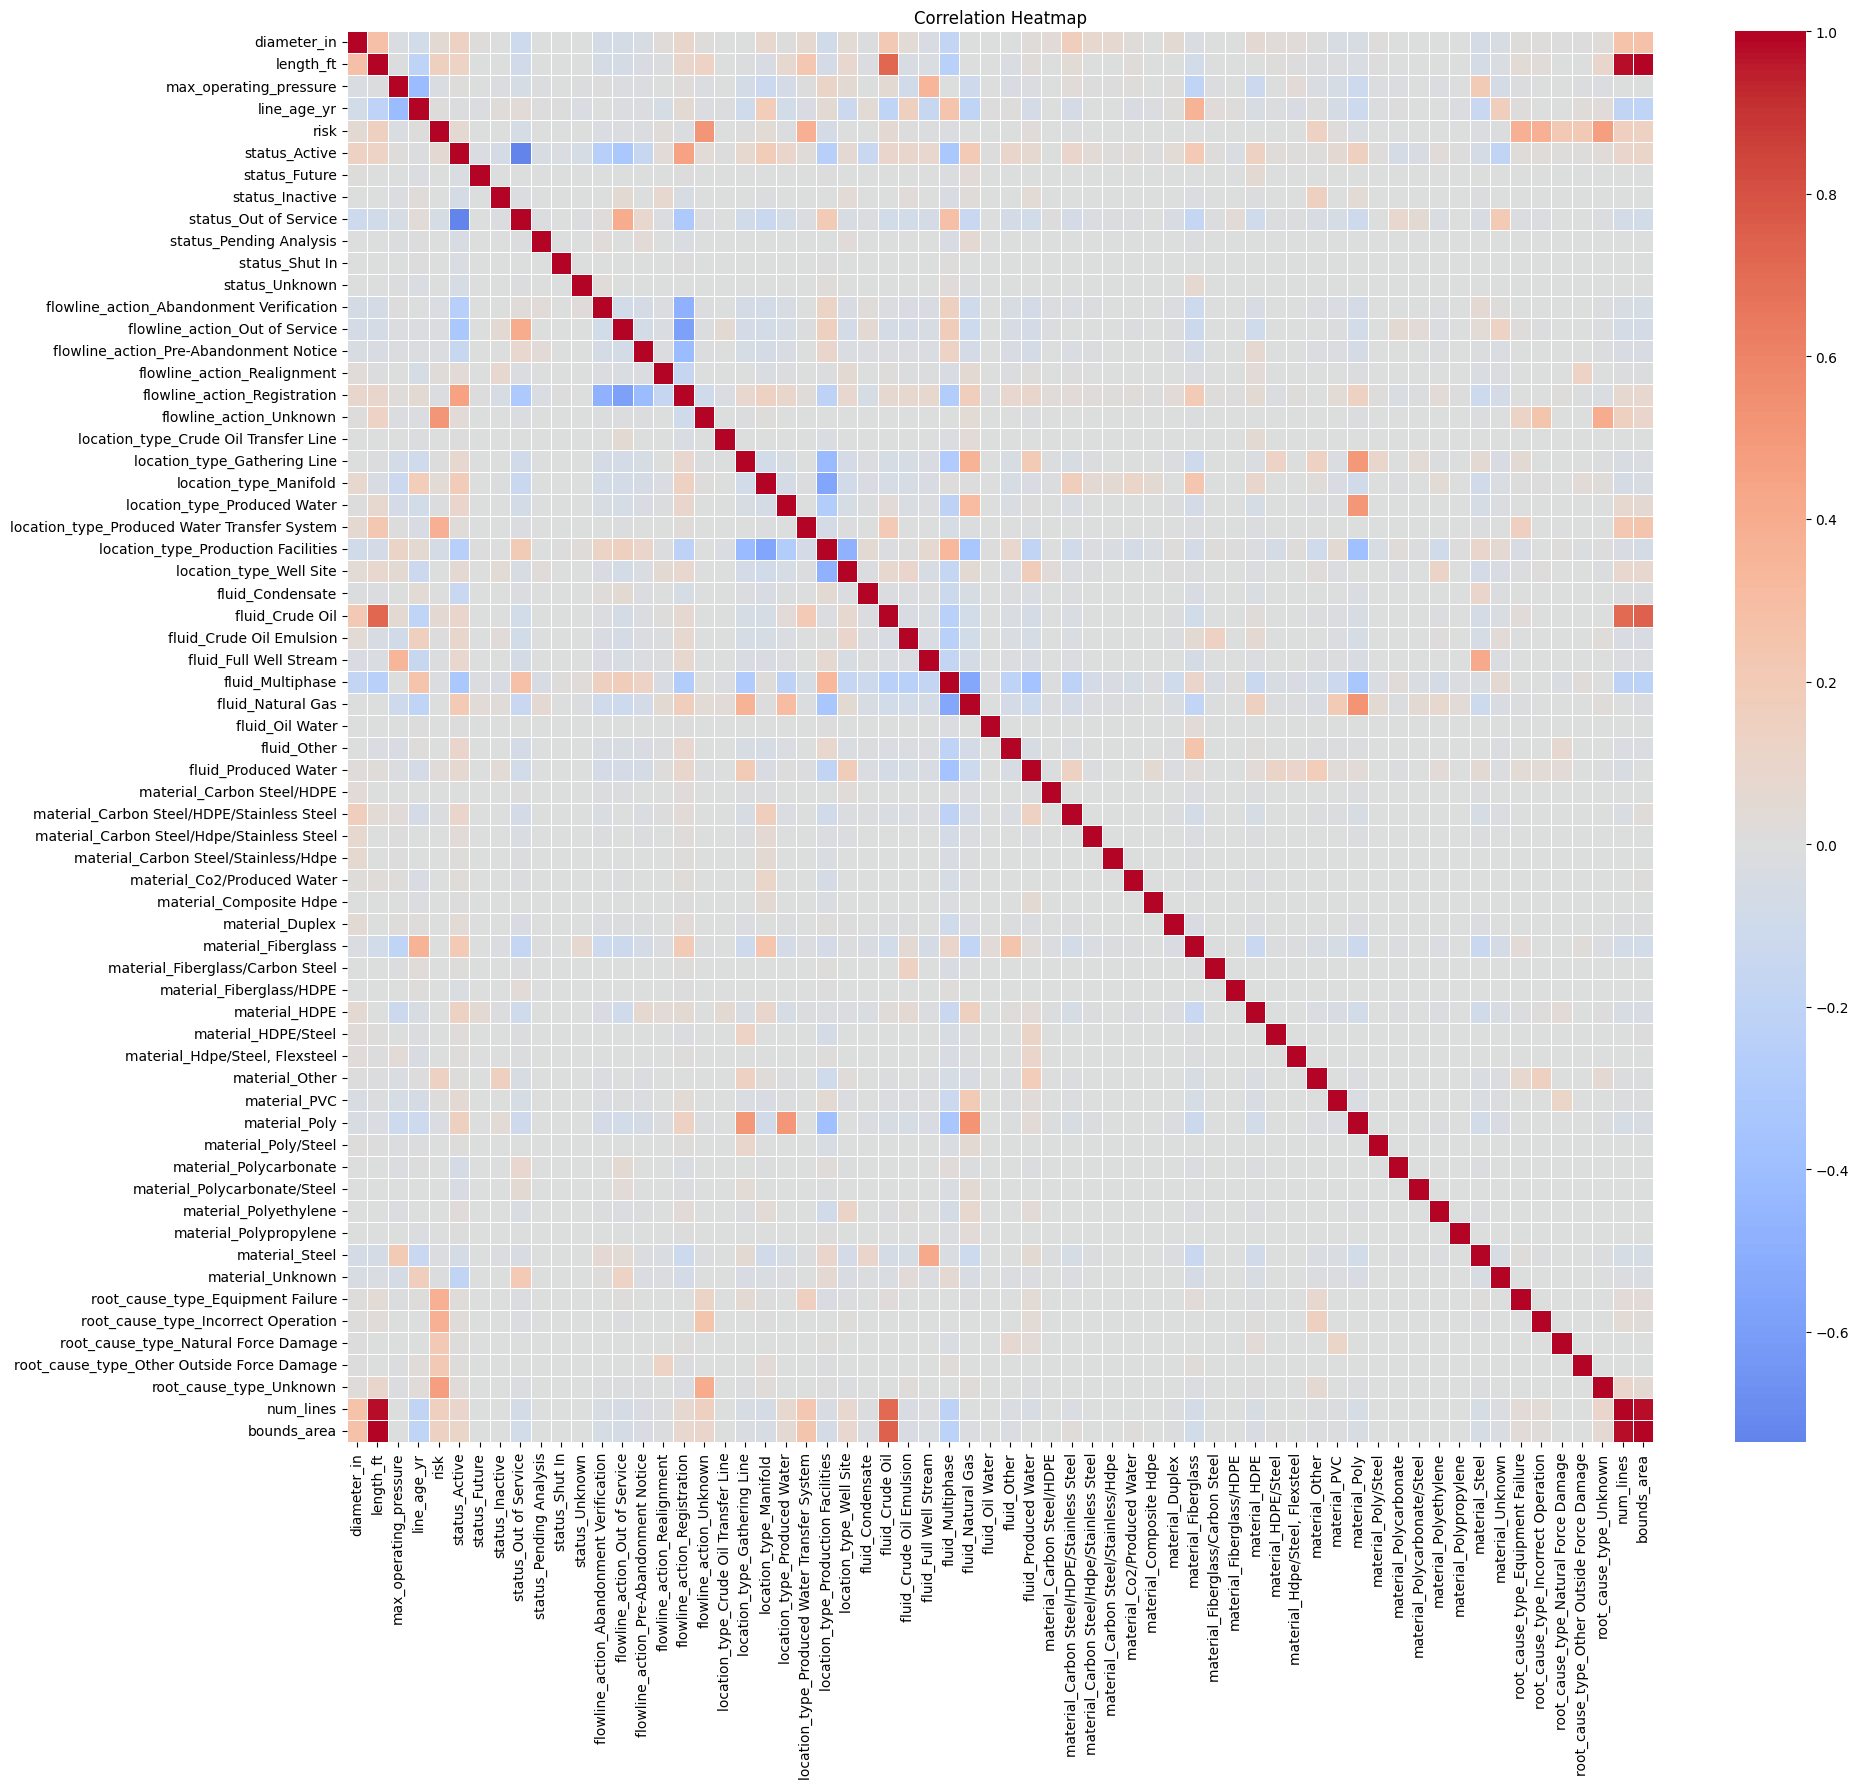

In [28]:
feature_names = complete_data_transformed.columns

# Compute correlation matrix
corr = complete_data_transformed[feature_names].corr()

# Filter for strong correlations only
# strong_corr = corr[(corr.abs() > 0.3) & (corr.abs() < 1.0)]  # exclude perfect correlation

# Plot heatmap
plt.figure(figsize=(20, 18))  # Bigger figure
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [29]:
feature_count = len(feature_names)
print("Number of features:", feature_count)

Number of features: 64


# Supervised ML Models

## Train-Test split

In [39]:
from sklearn.preprocessing import StandardScaler

# Prepare data
inputs = complete_data_transformed.drop(columns=['risk'])
outputs = complete_data_transformed['risk']

trainX, testX, trainY, testY = train_test_split(
    inputs, outputs,
    test_size=0.3,
    random_state=42,
    stratify=outputs
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(trainX)
X_test_scaled = scaler.transform(testX) 


## Models

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', C=1.0),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Store predictions and models
model_results = {}
model_predictions = {}

for name, clf in classifiers.items():
    print(f"\n--- {name} ---")
    
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])
    
    pipe.fit(X_train_scaled, trainY)
    
    y_train_pred = pipe.predict(X_train_scaled)
    y_test_pred = pipe.predict(X_test_scaled)

    if name == "Logistic Regression":
        best_no_pca_preds = pd.Series(y_test_pred, index=testX.index)

    acc_train = accuracy_score(trainY, y_train_pred)
    acc_test = accuracy_score(testY, y_test_pred)
    f1_train = f1_score(trainY, y_train_pred, pos_label=1)
    f1_test = f1_score(testY, y_test_pred, pos_label=1)
    
    print(f"Train Accuracy: {acc_train:.4f} | Test Accuracy: {acc_test:.4f}")
    print(f"Train F1 Score: {f1_train:.4f} | Test F1 Score: {f1_test:.4f}")
    
    print("Confusion Matrix (Test):")
    print(confusion_matrix(testY, y_test_pred))
    
    print("Classification Report (Test):")
    print(classification_report(testY, y_test_pred, zero_division=0))

    model_results[name] = {
        "acc_train": acc_train,
        "acc_test": acc_test,
        "f1_train": f1_train,
        "f1_test": f1_test
    }


--- Logistic Regression ---
Train Accuracy: 0.9983 | Test Accuracy: 0.9976
Train F1 Score: 0.9057 | Test F1 Score: 0.8696
Confusion Matrix (Test):
[[1235    1]
 [   2   10]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1236
           1       0.91      0.83      0.87        12

    accuracy                           1.00      1248
   macro avg       0.95      0.92      0.93      1248
weighted avg       1.00      1.00      1.00      1248


--- K-Nearest Neighbors ---
Train Accuracy: 0.9973 | Test Accuracy: 0.9976
Train F1 Score: 0.8400 | Test F1 Score: 0.8571
Confusion Matrix (Test):
[[1236    0]
 [   3    9]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1236
           1       1.00      0.75      0.86        12

    accuracy                           1.00      1248
   macro avg       1.00      0.88      0.93  

## Models with PCA

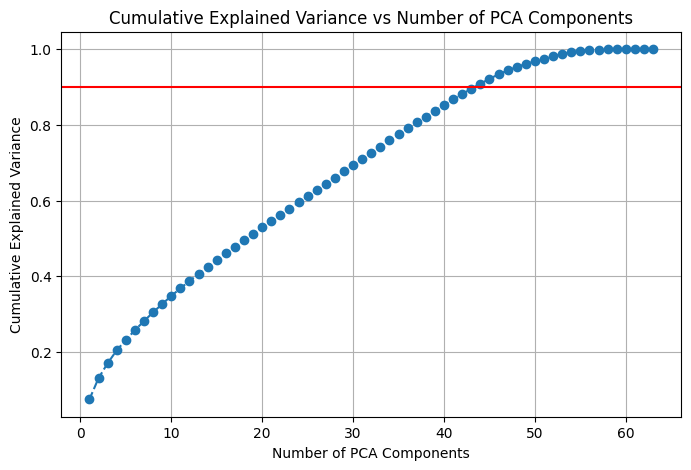

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Fit PCA without limiting components to examine all possible components
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of PCA Components')
plt.grid()
plt.axhline(y=0.9, color='r', linestyle='-')  # Example threshold (90%)
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler

# Then refit PCA
pca = PCA(n_components=2)
pca.fit(X_train_scaled)

PCA(n_components=2)

### Details of PCA

In [ ]:
# Feature names (column names from input data)
feature_names = trainX.columns

# Create a DataFrame of PCA component loadings
pca_loadings = pd.DataFrame(pca.components_.T,
                            columns=["PC1", "PC2"],
                            index=feature_names)

# Add absolute values to help rank features by magnitude
pca_loadings["Abs_PC1"] = np.abs(pca_loadings["PC1"])
pca_loadings["Abs_PC2"] = np.abs(pca_loadings["PC2"])
# pca_loadings["Abs_PC3"] = np.abs(pca_loadings["PC3"])
# pca_loadings["Abs_PC4"] = np.abs(pca_loadings["PC4"])

# Display top contributors
print("\nTop 5 features contributing to PC1:")
print(pca_loadings.sort_values("Abs_PC1", ascending=False)[["PC1"]].head(5))

print("\nTop 5 features contributing to PC2:")
print(pca_loadings.sort_values("Abs_PC2", ascending=False)[["PC2"]].head(5))

# print("\nTop 5 features contributing to PC3:")
# print(pca_loadings.sort_values("Abs_PC3", ascending=False)[["PC3"]].head(5))

# print("\nTop 5 features contributing to PC4:")
# print(pca_loadings.sort_values("Abs_PC4", ascending=False)[["PC4"]].head(5))

# Print explained variance
explained_variance = pca.explained_variance_ratio_
print("\nExplained variance by PC1 and PC2:", explained_variance)
print("Total variance explained:", explained_variance.sum())


Top 5 features contributing to PC1:
                      PC1
length_ft        0.389606
bounds_area      0.383689
num_lines        0.375131
diameter_in      0.333562
fluid_Crude Oil  0.318440

Top 5 features contributing to PC2:
                                          PC2
location_type_Production Facilities  0.308306
fluid_Natural Gas                   -0.277665
num_lines                            0.275628
bounds_area                          0.269872
material_Poly                       -0.267661

Explained variance by PC1 and PC2: [0.07545974 0.05567431]
Total variance explained: 0.13113404893241334


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', C=1.0),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Store results
pca_results = {}

# Adjust this if you want more components
N_COMPONENTS = 2

for name, clf in classifiers.items():
    print(f"\n--- {name} with PCA ---")
    
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=N_COMPONENTS)),
        ('classifier', clf)
    ])
    
    # Fit model
    pipe.fit(X_train_scaled, trainY)
    
    # Predict on train and test
    y_train_pred = pipe.predict(X_train_scaled)
    y_test_pred = pipe.predict(X_test_scaled)

    if name == "Gradient Boosting":
        best_pca_preds = pd.Series(y_test_pred, index=testX.index)
    
    # Scores
    acc_train = accuracy_score(trainY, y_train_pred)
    acc_test = accuracy_score(testY, y_test_pred)
    f1_train = f1_score(trainY, y_train_pred, pos_label=1)
    f1_test = f1_score(testY, y_test_pred, pos_label=1)
    
    print(f"Train Accuracy: {acc_train:.4f} | Test Accuracy: {acc_test:.4f}")
    print(f"Train F1 Score: {f1_train:.4f} | Test F1 Score: {f1_test:.4f}")
    
    print("Confusion Matrix (Test):")
    print(confusion_matrix(testY, y_test_pred))
    
    print("Classification Report (Test):")
    print(classification_report(testY, y_test_pred, zero_division=0))

    pca_results[name] = {
        "acc_train": acc_train,
        "acc_test": acc_test,
        "f1_train": f1_train,
        "f1_test": f1_test
    }


--- Logistic Regression with PCA ---
Train Accuracy: 0.9900 | Test Accuracy: 0.9896
Train F1 Score: 0.0000 | Test F1 Score: 0.0000
Confusion Matrix (Test):
[[1235    1]
 [  12    0]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1236
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1248
   macro avg       0.50      0.50      0.50      1248
weighted avg       0.98      0.99      0.99      1248


--- K-Nearest Neighbors with PCA ---
Train Accuracy: 0.9931 | Test Accuracy: 0.9920
Train F1 Score: 0.4737 | Test F1 Score: 0.3750
Confusion Matrix (Test):
[[1235    1]
 [   9    3]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1236
           1       0.75      0.25      0.38        12

    accuracy                           0.99      1248
   macro avg       0.87    

## Models with CCA

### Details of CCA

In [ ]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# One-hot encode targets for CCA
encoder = OneHotEncoder(sparse_output=False)
Y_train_encoded = encoder.fit_transform(trainY.values.reshape(-1, 1))

cca = CCA(n_components=2)
cca.fit(X_train_scaled, Y_train_encoded)

# Canonical weights for input features (same shape as PCA.components_.T)
cca_weights = pd.DataFrame(
    cca.x_weights_,
    index=trainX.columns,
    columns=["Canonical 1", "Canonical 2"]
)

# Add absolute values to rank importance
cca_weights["Abs_C1"] = np.abs(cca_weights["Canonical 1"])
cca_weights["Abs_C2"] = np.abs(cca_weights["Canonical 2"])

# Top contributors
print("\nTop 5 features contributing to Canonical 1:")
print(cca_weights.sort_values("Abs_C1", ascending=False)[["Canonical 1"]].head(5))

print("\nTop 5 features contributing to Canonical 2:")
print(cca_weights.sort_values("Abs_C2", ascending=False)[["Canonical 2"]].head(5))


Top 5 features contributing to Canonical 1:
                                              Canonical 1
location_type_Produced Water Transfer System     0.473684
flowline_action_Unknown                          0.428694
root_cause_type_Unknown                          0.415709
root_cause_type_Incorrect Operation              0.341643
root_cause_type_Natural Force Damage             0.332114

Top 5 features contributing to Canonical 2:
                                      Canonical 2
bounds_area                          1.332268e-14
location_type_Production Facilities  7.382983e-15
length_ft                           -6.994405e-15
location_type_Manifold               6.411538e-15
num_lines                            4.884981e-15


In [ ]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import pandas as pd

# Apply CCA using risk as a continuous soft-label
cca = CCA(n_components=1)
X_train_cca, _ = cca.fit_transform(X_train_scaled, trainY.values.reshape(-1, 1))
X_test_cca, _ = cca.transform(X_test_scaled, testY.values.reshape(-1, 1))

# Define classifiers
classifiers = {
    "Logistic Regression (CCA)": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors (CCA)": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine (CCA)": SVC(kernel='rbf', C=1.0),
    "Gradient Boosting (CCA)": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost (CCA)": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    "Random Forest (CCA)": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Evaluate all classifiers
cca_results = {}

for name, clf in classifiers.items():
    print(f"\n--- {name} ---")

    clf.fit(X_train_cca, trainY)

    y_train_pred = clf.predict(X_train_cca)
    y_test_pred = clf.predict(X_test_cca)

    acc_train = accuracy_score(trainY, y_train_pred)
    acc_test = accuracy_score(testY, y_test_pred)
    f1_train = f1_score(trainY, y_train_pred, pos_label=1)
    f1_test = f1_score(testY, y_test_pred, pos_label=1)

    print(f"Train Accuracy: {acc_train:.4f} | Test Accuracy: {acc_test:.4f}")
    print(f"Train F1 Score: {f1_train:.4f} | Test F1 Score: {f1_test:.4f}")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(testY, y_test_pred))
    print("Classification Report (Test):")
    print(classification_report(testY, y_test_pred, zero_division=0))

    cca_results[name] = {
        "acc_train": acc_train,
        "acc_test": acc_test,
        "f1_train": f1_train,
        "f1_test": f1_test
    }


--- Logistic Regression (CCA) ---
Train Accuracy: 0.9983 | Test Accuracy: 0.9976
Train F1 Score: 0.9057 | Test F1 Score: 0.8696
Confusion Matrix (Test):
[[1235    1]
 [   2   10]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1236
           1       0.91      0.83      0.87        12

    accuracy                           1.00      1248
   macro avg       0.95      0.92      0.93      1248
weighted avg       1.00      1.00      1.00      1248


--- K-Nearest Neighbors (CCA) ---
Train Accuracy: 0.9983 | Test Accuracy: 0.9976
Train F1 Score: 0.9057 | Test F1 Score: 0.8696
Confusion Matrix (Test):
[[1235    1]
 [   2   10]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1236
           1       0.91      0.83      0.87        12

    accuracy                           1.00      1248
   macro avg       0.95      0.92

# Unsupervised ML Models

## K-Means Cluster

Silhouette Score for 2 clusters: 0.9895099885951896
Silhouette Score for 3 clusters: 0.9611853786276054
Silhouette Score for 4 clusters: 0.9622302392819506
Silhouette Score for 5 clusters: 0.9527215845055322


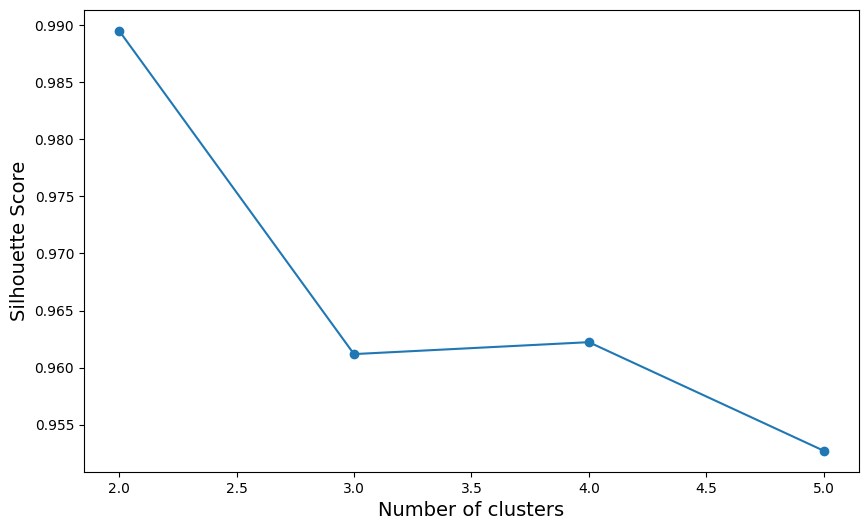

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn as sk

# Prepare data
inputs = complete_data_transformed.drop(columns=['risk'])
outputs = complete_data_transformed['risk']

# Define PCA with 2 components and transform inputs
pca = PCA(n_components=2)
inputs_pca = pca.fit_transform(inputs)

# Range of clusters to try
clusters_range = [2, 3, 4, 5]
silhouette_scores = []

for n_clusters in clusters_range:
    # Create K-means model with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(inputs_pca)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(inputs_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters', fontsize=14)  # Increased font size
plt.ylabel('Silhouette Score', fontsize=14)
# plt.title('Silhouette Score by Cluster Number')
plt.show()

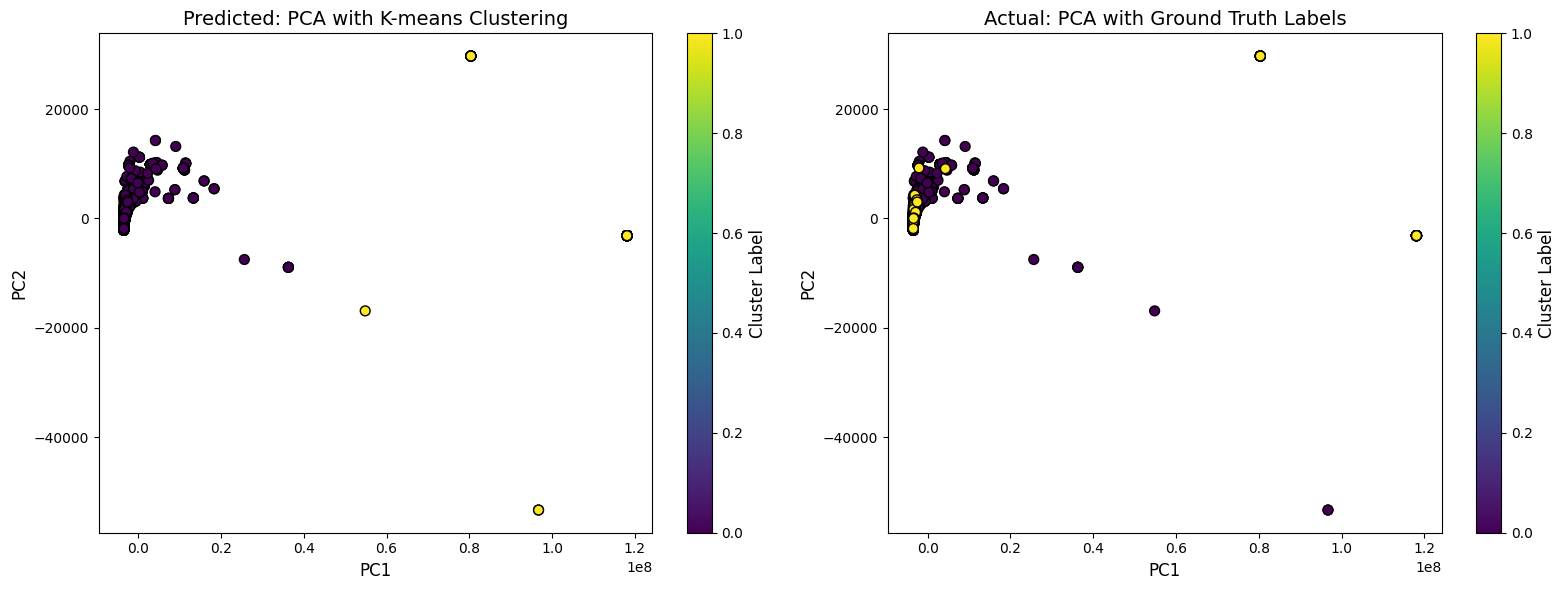

In [131]:
import matplotlib.pyplot as plt

# Visualization
kmeans = KMeans(n_clusters=2, random_state=42)
y_hat = kmeans.fit_predict(inputs_pca)

unsupervised_preds = pd.Series(y_hat, index=inputs.index)
unsupervised_test_preds = unsupervised_preds.loc[testX.index]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Predicted cluster assignment
sc1 = axs[0].scatter(inputs_pca[:, 0], inputs_pca[:, 1], c=y_hat, cmap='viridis', marker='o', edgecolor='k', s=50)
axs[0].set_xlabel('PC1', fontsize=12)  # Increased font size
axs[0].set_ylabel('PC2', fontsize=12)
axs[0].set_title('Predicted: PCA with K-means Clustering', fontsize=14)
cbar1 = plt.colorbar(sc1, ax=axs[0])
cbar1.set_label('Cluster Label', fontsize=12)

# Plot 2: Actual labels
sc2 = axs[1].scatter(inputs_pca[:, 0], inputs_pca[:, 1], c=outputs, cmap='viridis', marker='o', edgecolor='k', s=50)
axs[1].set_xlabel('PC1', fontsize=12)  # Increased font size
axs[1].set_ylabel('PC2', fontsize=12)
axs[1].set_title('Actual: PCA with Ground Truth Labels', fontsize=14)
cbar2 = plt.colorbar(sc2, ax=axs[1])
cbar2.set_label('Cluster Label', fontsize=12)

plt.tight_layout()
plt.show()

# Plot Predictions

In [111]:
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def plot_spatial_comparison_vertical(complete_data, test_index, preds_dict):
    """
    Plots multiple risk prediction maps vertically (stacked).
    
    Parameters:
    - complete_data: GeoDataFrame
    - test_index: Index used for filtering
    - preds_dict: Dictionary {title: prediction_series}
    """
    fig, axes = plt.subplots(len(preds_dict), 1, figsize=(12, 18))

    if len(preds_dict) == 1:
        axes = [axes]

    for ax, (title, preds) in zip(axes, preds_dict.items()):
        gdf = complete_data.loc[test_index].copy()
        gdf = gdf.to_crs(epsg=3857)
        gdf['risk'] = preds
        gdf = gdf.sort_values(by='risk')

        gdf.plot(column='risk', ax=ax,
                 cmap=ListedColormap(['blue', 'red']),
                 norm=Normalize(vmin=0, vmax=1),
                 alpha=0.7, linewidth=2)

        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])

    # Shared legend
    blue_patch = mpatches.Patch(color='blue', label='Low Risk')
    red_patch = mpatches.Patch(color='red', label='High Risk')
    plt.legend(handles=[blue_patch, red_patch],
               loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    
    plt.tight_layout()
    plt.show()

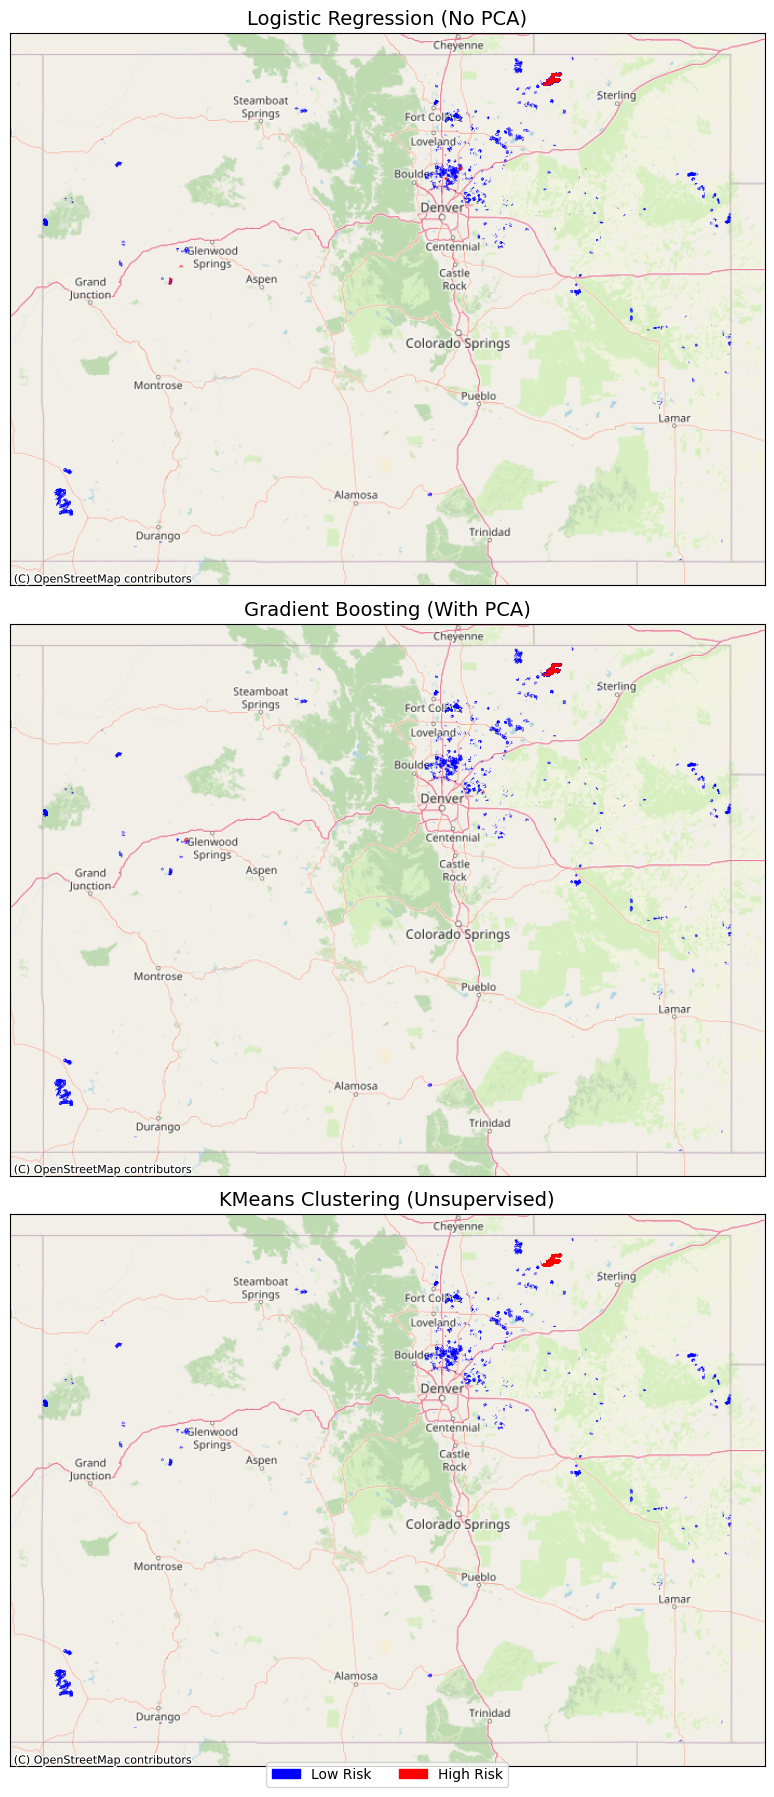

In [112]:
plot_spatial_comparison_vertical(
    complete_data,
    testX.index,
    {
        "Logistic Regression (No PCA)": best_no_pca_preds,
        "Gradient Boosting (With PCA)": best_pca_preds,
        "KMeans Clustering (Unsupervised)": unsupervised_test_preds
    }
)